In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load Dataset

Dataset Original Length n:  10358
Dataset Sampled Length n:  10358


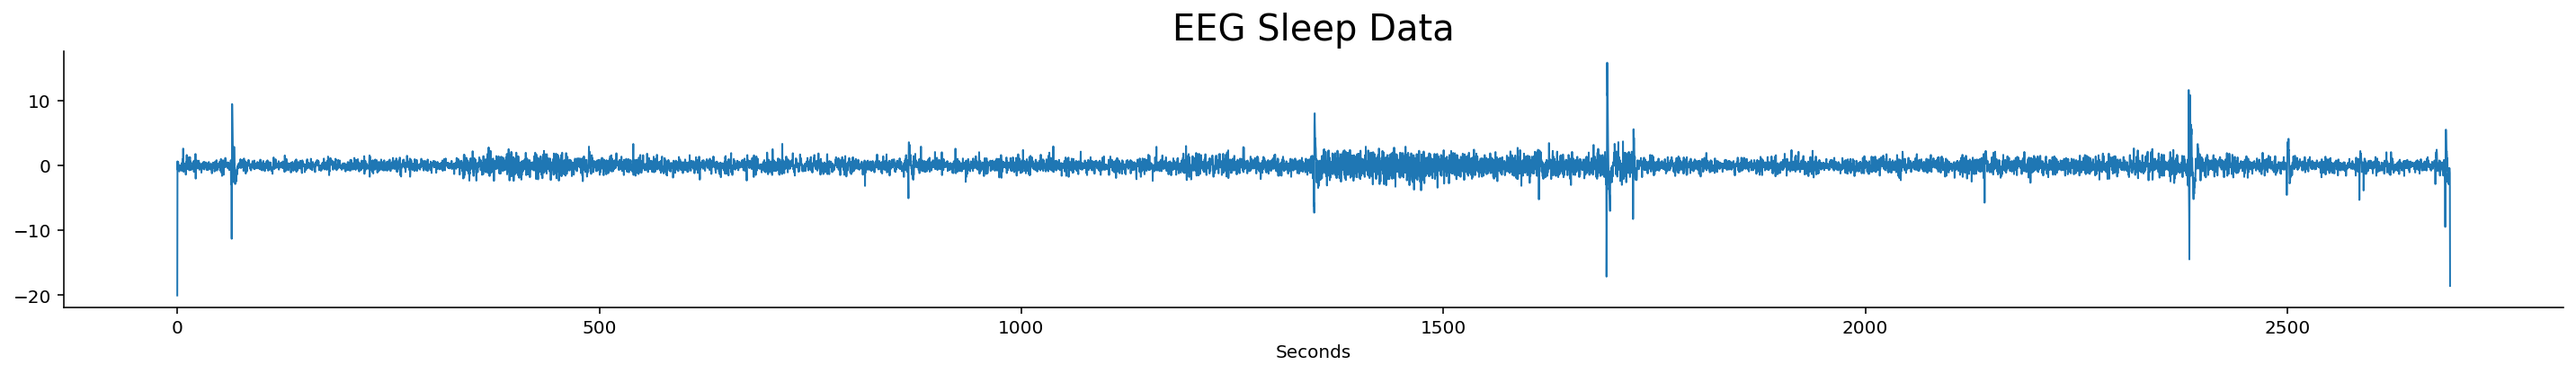

In [2]:
file = 'npo141.csv' # Dataset Length n:  269286
ds_name="EEG Sleep Data"
series = ml.read_dataset_with_index(file) 
data = series.values
#series = ml.as_series(data, np.arange(0, 269286, 26) / 100, 'Seconds')
plot_dataset(file, series, ds_name=ds_name)

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df_comp = pd.DataFrame(columns=["Method", "Motif", "Extent", "k"]) # Complete Info


rerun_all_jars = False
motif_length = 115
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets/notebooks/../datasets/npo141.csv


# k-Motiflets

Compute ks: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:19<00:00,  1.07s/it]


Chosen window-size: 115


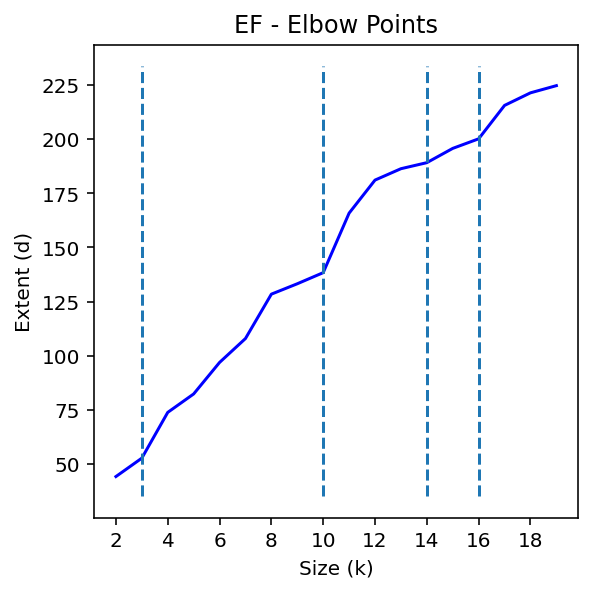

Identified Elbow Points [ 3 10 14 16]
Filtered Elbow Points [3, 16]


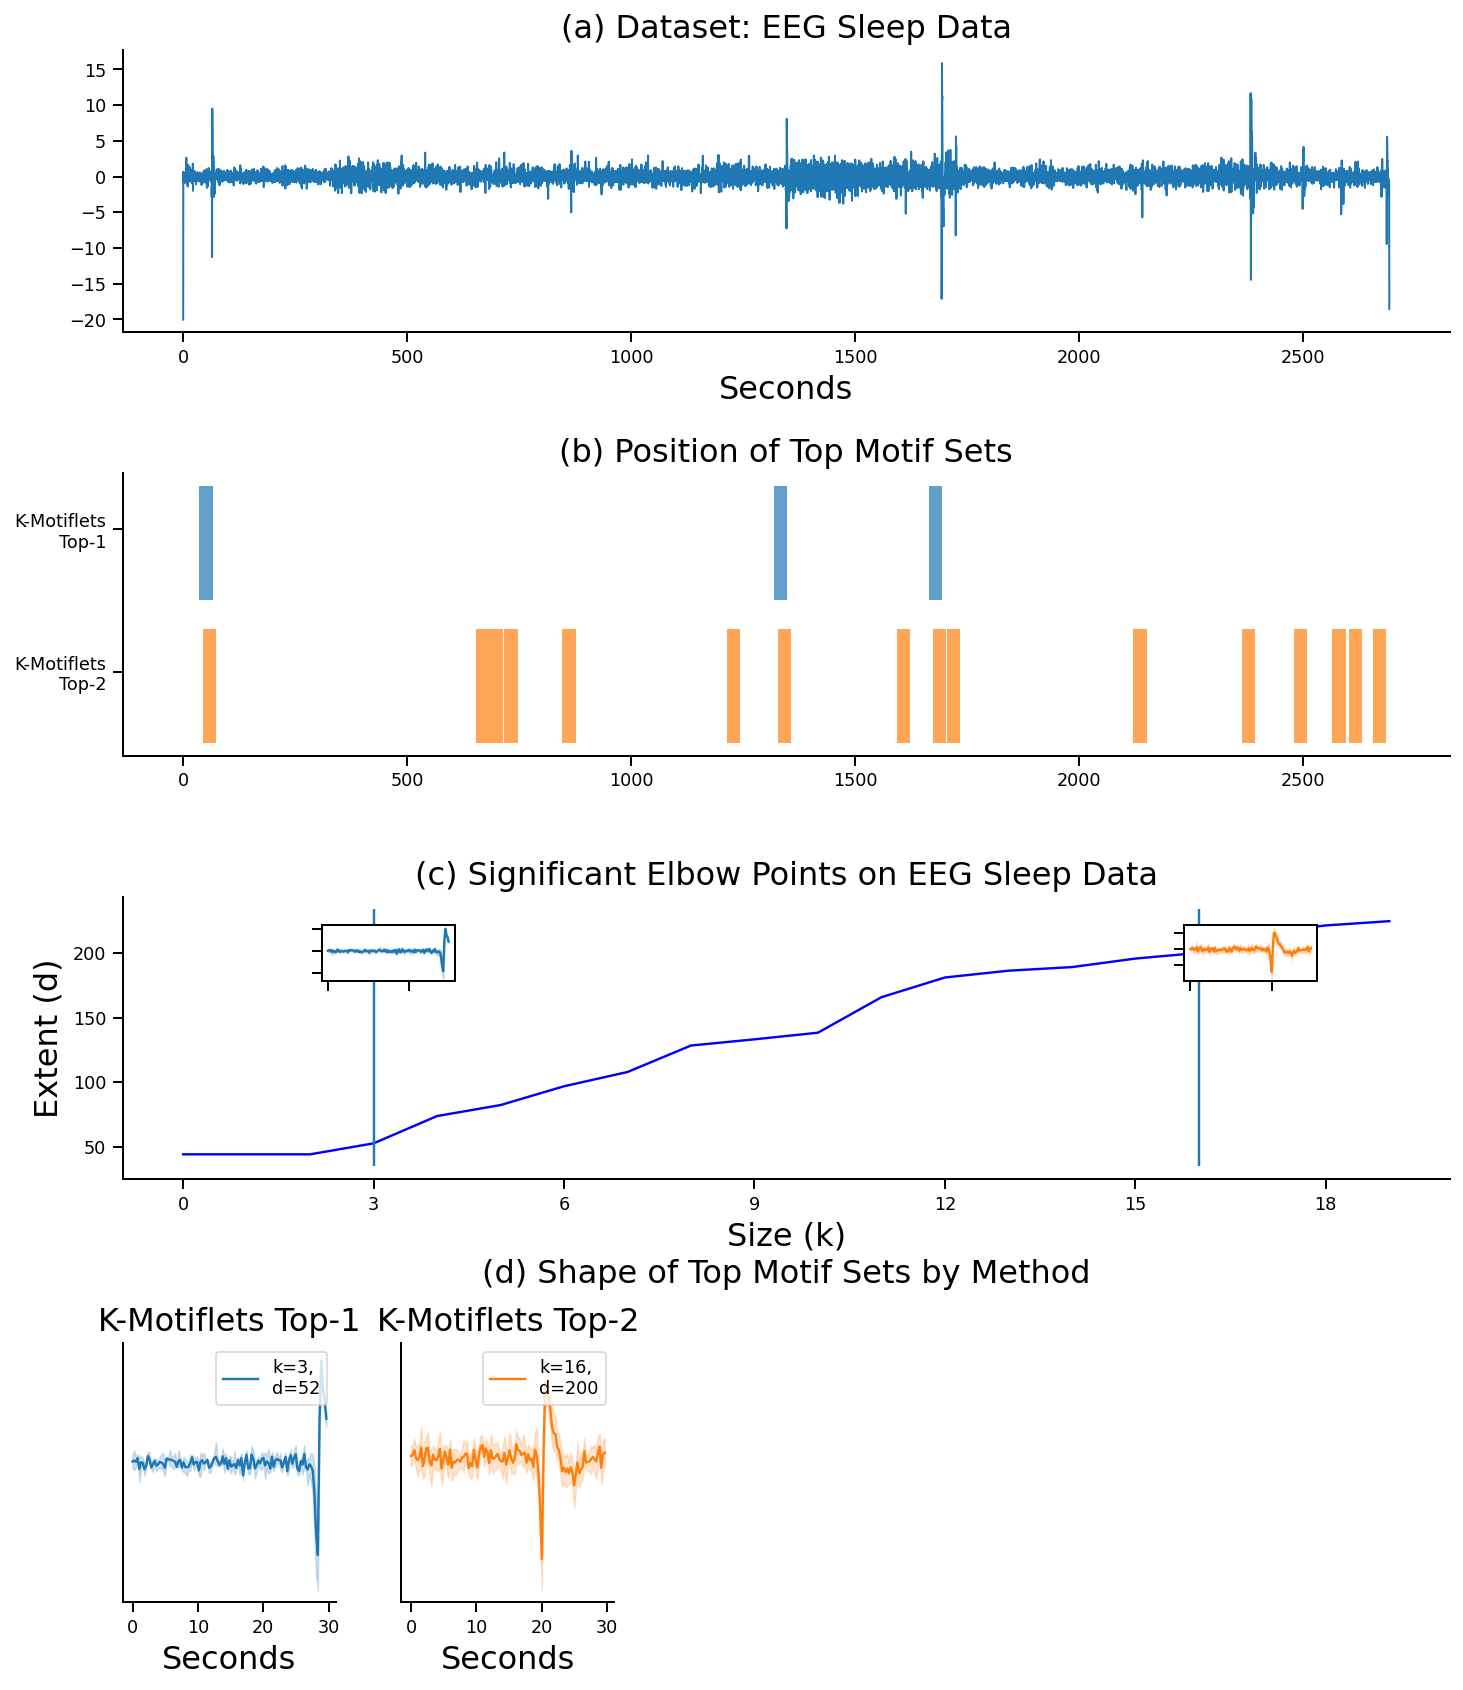

In [4]:
dists, motiflets, elbow_points = plot_elbow(
    20, series, file, ds_name=ds_name, plot_elbows=True, 
    motif_length=motif_length, method_name="K-Motiflets")

In [5]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df_comp = append_all_motif_sets(df_comp, motiflets, "Motiflets", D_full)

# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [6]:
max_r = 100
radii = np.arange(50, max_r + 1, max(1, int(max_r / 10)))
print("Radii", radii)

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(radii)),
       str(motif_length)])

Radii [ 50  60  70  80  90 100]


r: 68.48294 d: 99.4703369140625
r: 80.06316 d: 94.98853302001953
r: 86.474724 d: 125.42115783691406
r: 88.083786 d: 131.92819213867188
Filtered Elbow Points [0, 3]


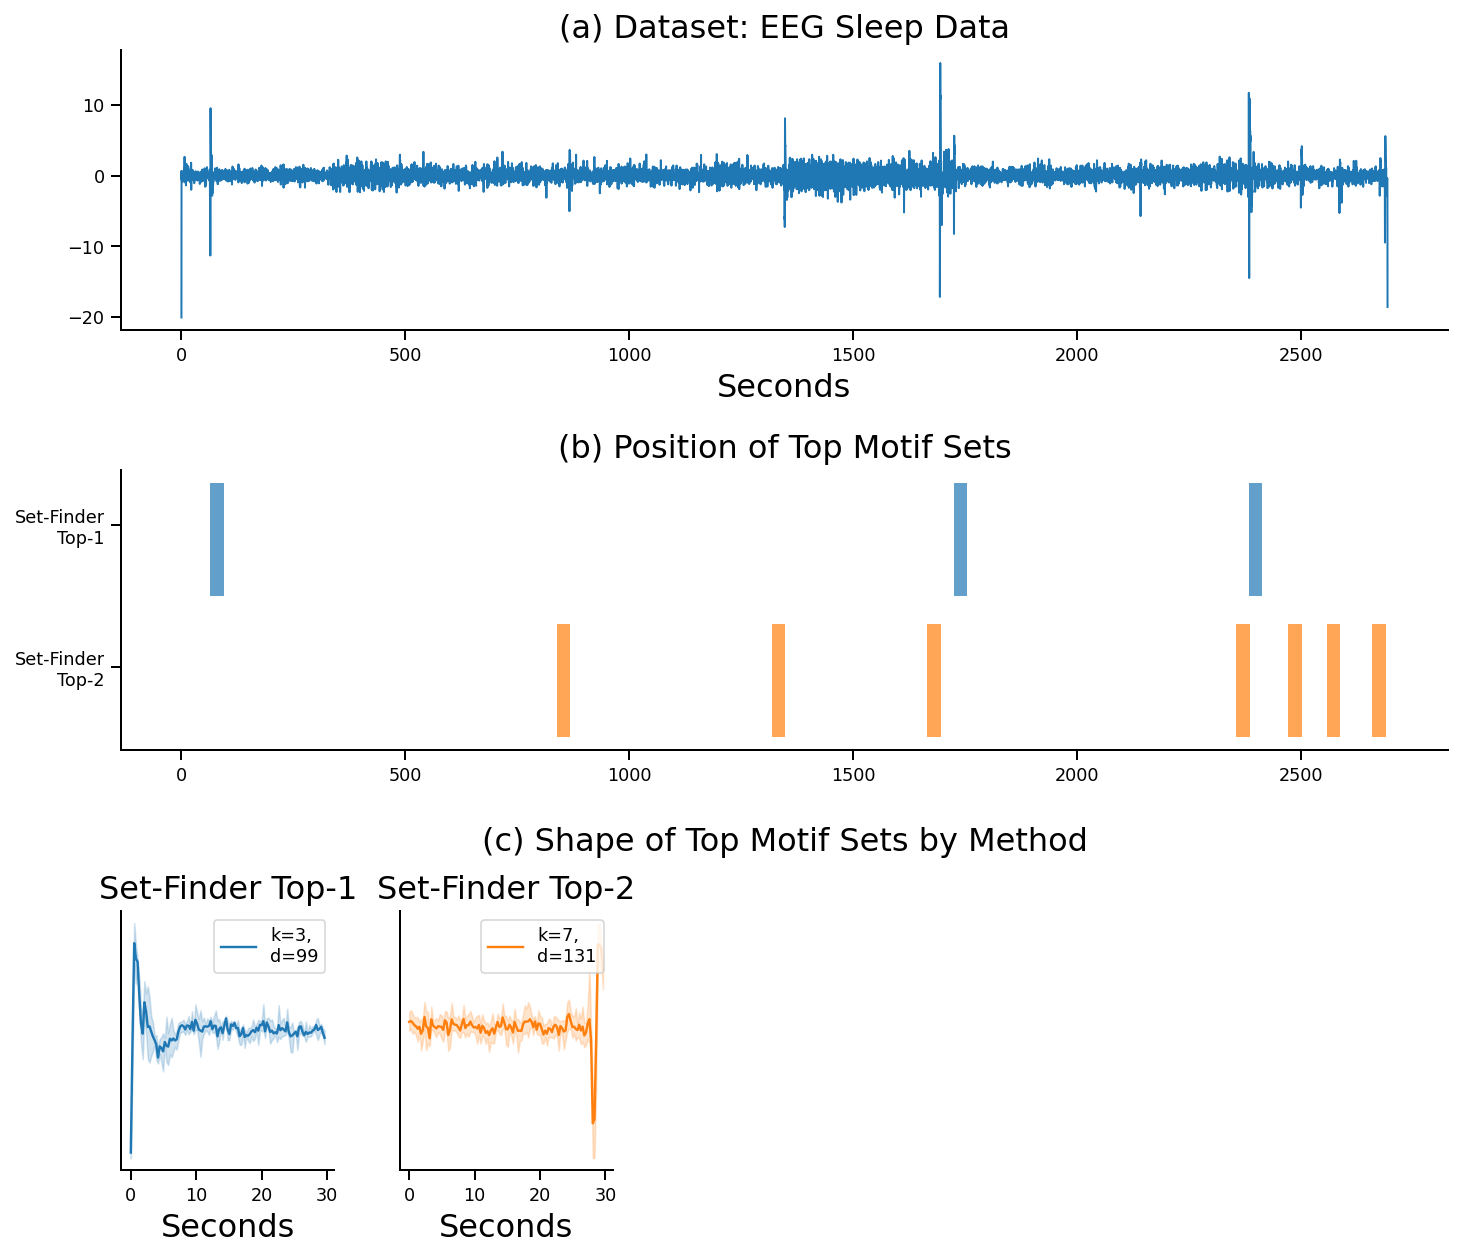

In [7]:
# run jave code first       
ms_set_finder = [
	[248, 6634, 9169],
	[5078, 6411, 9512, 10233],
	[6406, 5072, 9061, 9506, 9837, 10227],
	[6405, 3223, 5071, 9060, 9505, 9836, 10226],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, prefix="Set-Finder")

df["Set Finder Top-1"] = [motifset[-1]]
df_comp = append_all_motif_sets(df_comp, ms_set_finder, "Set Finder", D_full)

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [8]:
max_r = 100
radii = np.arange(50, max_r + 1, max(1, int(max_r / 10)))
print("Radii", radii)

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(radii)),
       str(motif_length)])

Radii [ 50  60  70  80  90 100]


r: 94.47069 d: 94.47068786621094
r: 78.36329 d: 78.36328887939453
r: 121.94757 d: 125.42115783691406
r: 109.57307 d: 141.45799255371094
r: 121.04392 d: 138.17901611328125
Filtered Elbow Points [2]


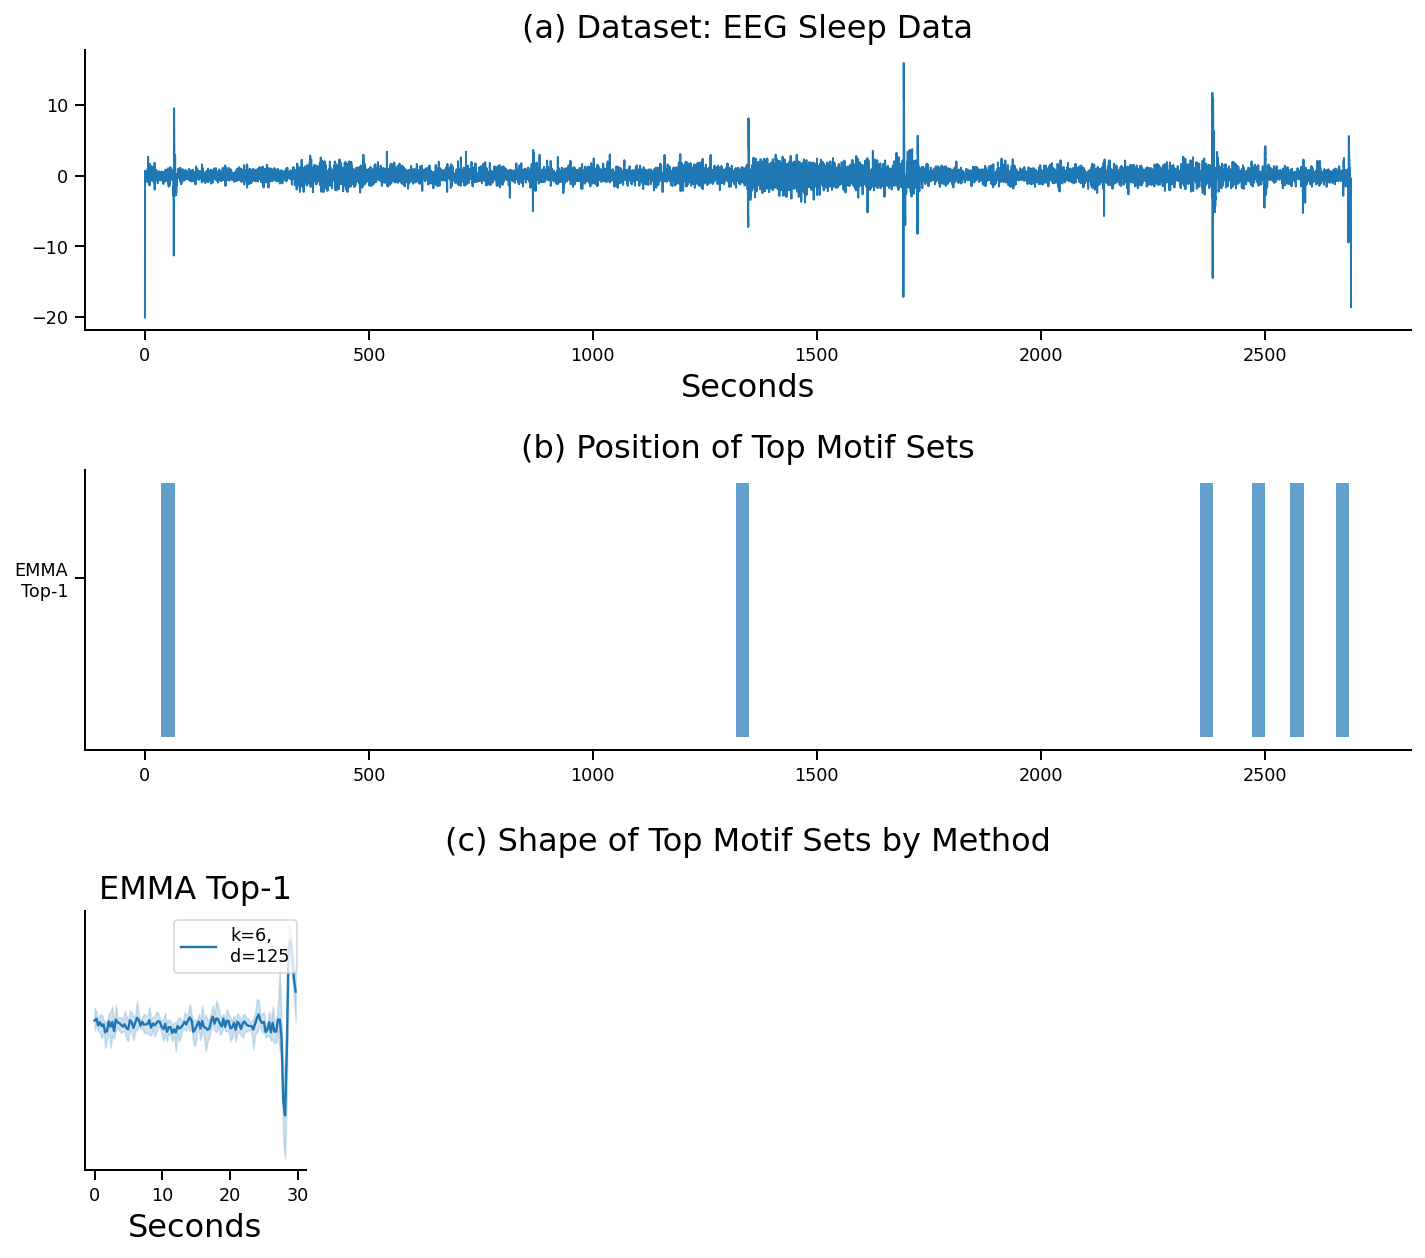

In [9]:
# run jave code first       
ms_emma = [
    [5073],
	[141, 5074, 10229],
	[139, 5071, 10226],
	[140, 5072, 9061, 9506, 9837, 10227],
	[250, 5182, 6636, 9177, 9616],
	[250, 5183, 6636, 9176, 9617],    
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")

df["EMMA Top-1"] = [motifset[-1]]
df_comp = append_all_motif_sets(df_comp, ms_emma, "EMMA", D_full)

# Valmod Motif Sets
based on own (fixed-length) implementation

r: 44.23978 d: 44.23978042602539
r: 95.37849 d: 95.37848663330078
r: 125.84643 d: 139.35340881347656
r: 151.16513 d: 168.15005493164062
r: 169.27927 d: 182.7958984375
Filtered Elbow Points [4]


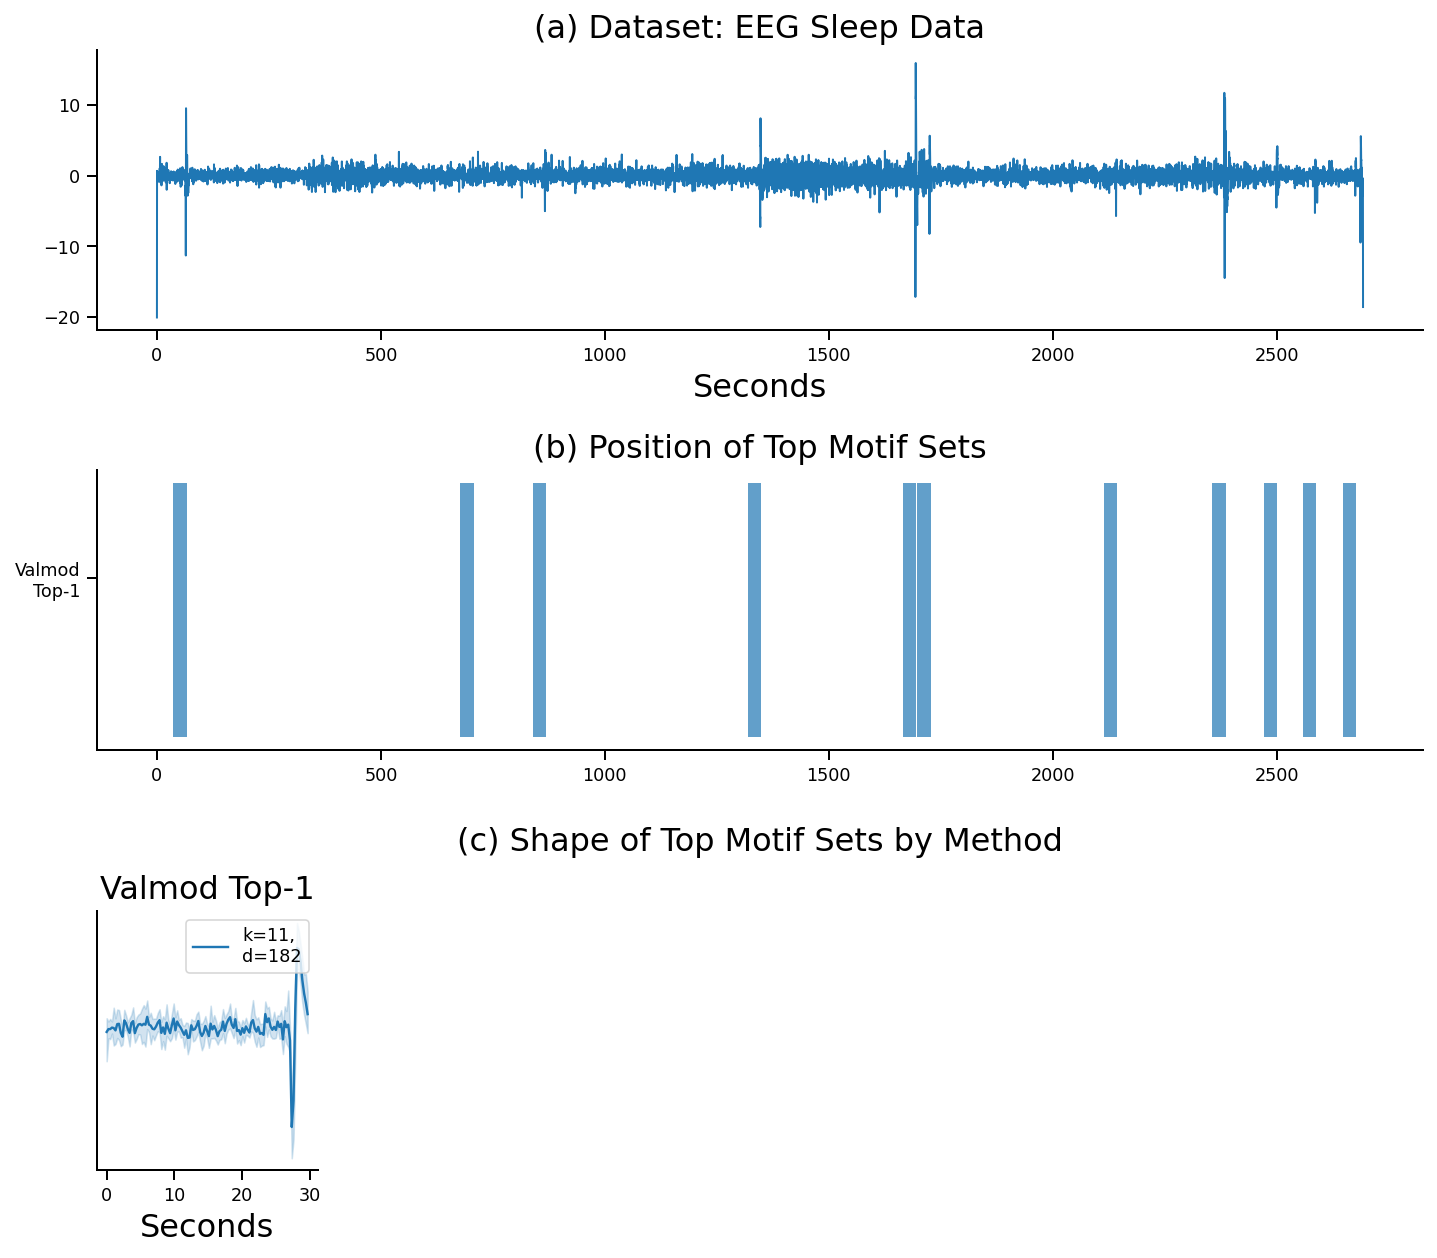

In [10]:
max_d = 200

data_raw = data.to_numpy() if isinstance(data, pd.Series) else data    
ms_valmod = [motifset for (motifset, _) in get_valmod_motif_set_ranged(data_raw, file, motif_length, max_d)]                                            
motifset = plot_competitors(series, ds_name, ms_valmod, motif_length, prefix="Valmod")

df["VALMOD Top-1"] = [motifset[-1]]
df_comp = append_all_motif_sets(df_comp, ms_valmod, "VALMOD", D_full)

# Learning Motifs
See Java Code

In [11]:
max_r = 100
radii = np.arange(50, max_r + 1, max(1, int(max_r / 10)))
print("Radii", radii)

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(radii)),
       str(motif_length)])

Radii [ 50  60  70  80  90 100]


r: 59.013397 d: 59.013397216796875
r: 119.08649 d: 119.08648681640625
r: 119.08649 d: 125.20208740234375
r: 149.1985 d: 171.70042419433594
r: 149.1985 d: 171.70042419433594
r: 156.12206 d: 170.0231475830078
Filtered Elbow Points [3]


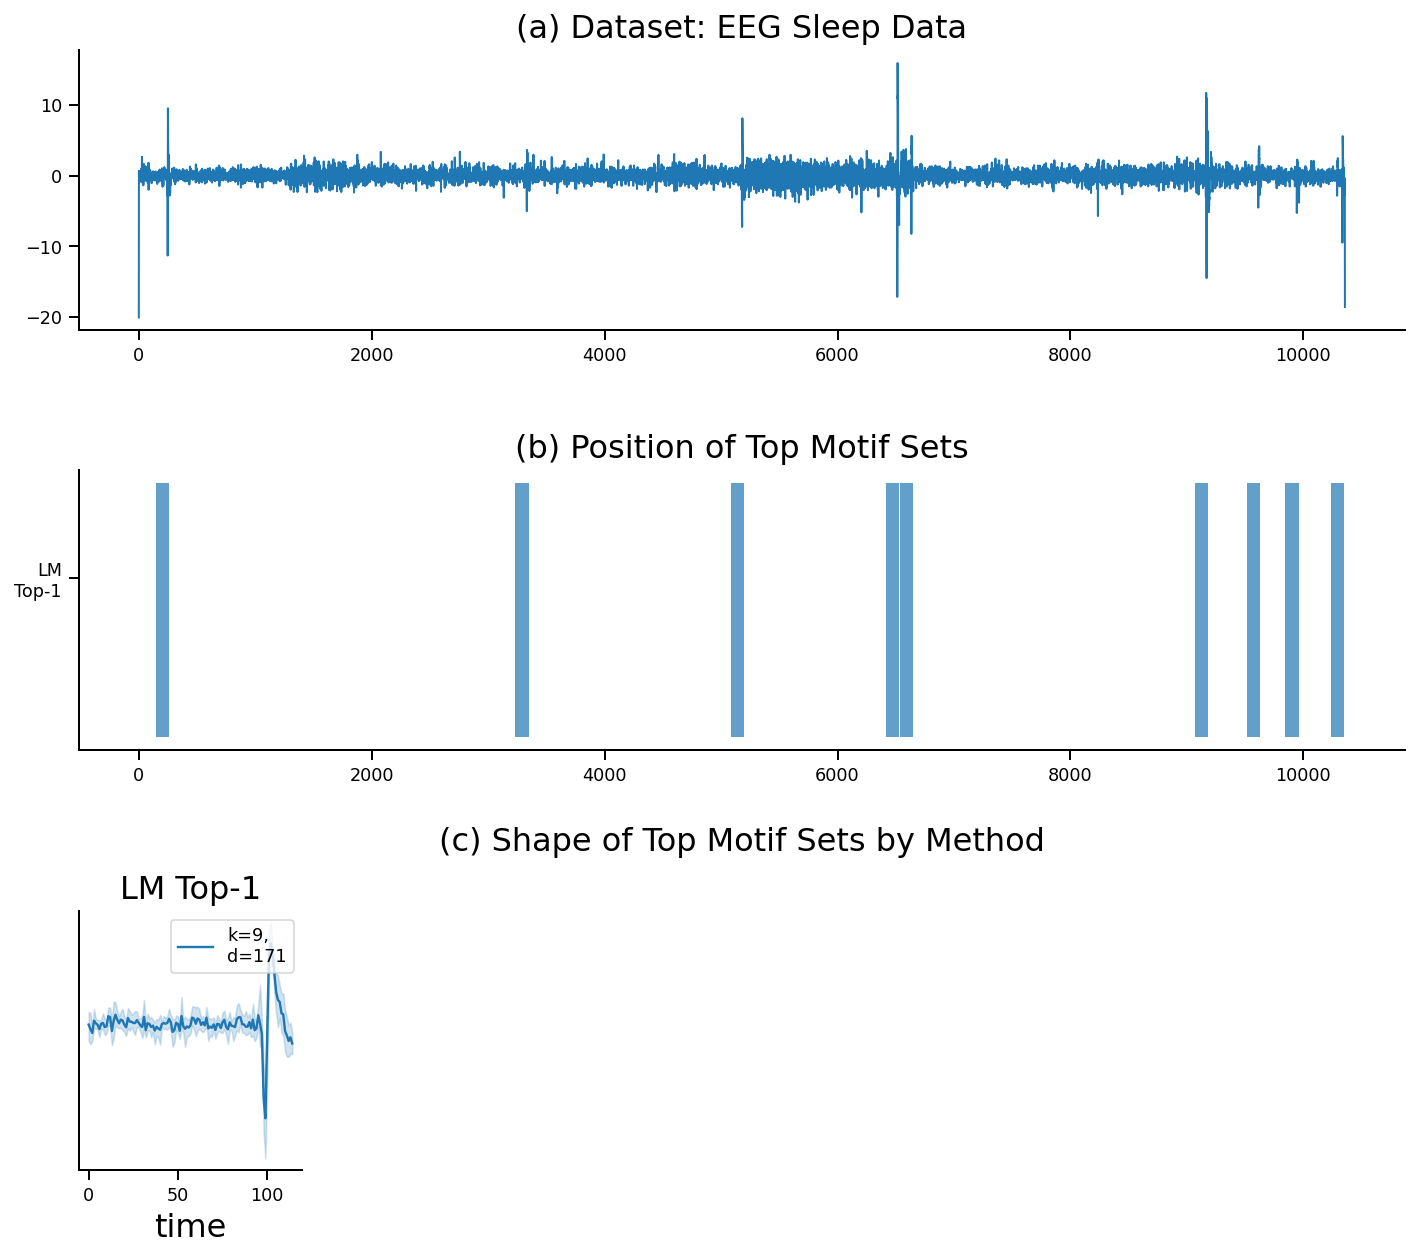

In [12]:
ms_learning_motifs = np.array([
    [137,5070,6403,],
	[149,5081,6415,9515,10236,],
	[149,3233,5081,6415,9515,10236,],
	[149,3233,5081,6414,6536,9070,9515,9846,10236,],
	[149,3233,5081,6414,6536,9070,9515,9846,10192,],
	[159,3244,5091,6425,10202,],
])
    
motifset = plot_competitors(data, ds_name, 
                            ms_learning_motifs, motif_length, 
                            prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df_comp = append_all_motif_sets(df_comp, ms_learning_motifs, "LM", D_full)

# Comparison

In [13]:
df_2 = df.T
df_2.rename(columns={0:"offsets"}, inplace=True)
df_2

,offsets
Motiflets Top-1,"[171, 6437, 9092, 5104, 3255, 6557, 9537, 8159..."
Set Finder Top-1,"[6405, 3223, 5071, 9060, 9505, 9836, 10226]"
EMMA Top-1,"[140, 5072, 9061, 9506, 9837, 10227]"
VALMOD Top-1,"[142, 2605, 3226, 5074, 6408, 6529, 8131, 9063..."
LM Top-1,"[149, 3233, 5081, 6414, 6536, 9070, 9515, 9846..."


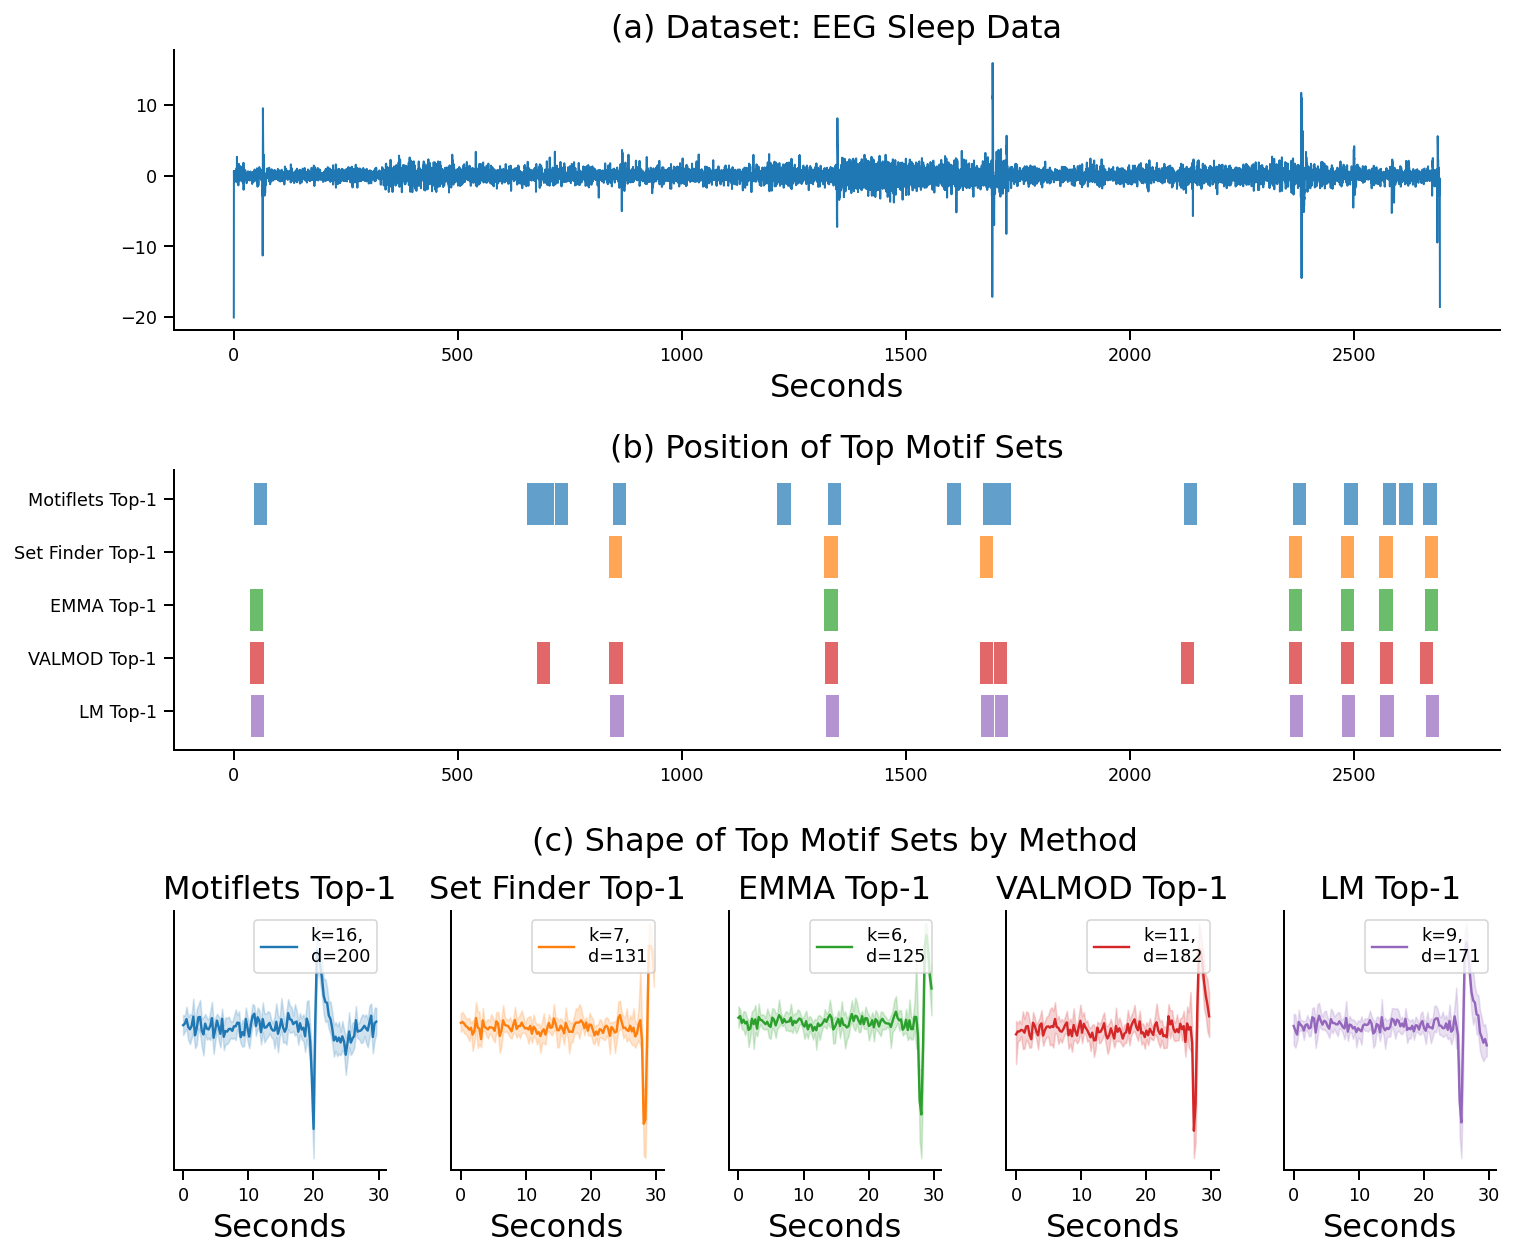

In [14]:
motifsets = np.array(df_2["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_2.index.values)

# Summary

In [15]:
extent = [ml.get_pairwise_extent(D_full, df_2.offsets[ind]) for ind in df_2.index]
count = [len(df_2.offsets[ind]) for ind in df_2.index]

df_statistics = pd.DataFrame(
    data=zip(df_2.index, extent, count), 
    columns=["Method", "Extent (d)", "Size (k)"])
df_statistics["Dataset"] = ds_name
display(df_statistics)

,Method,Extent (d),Size (k),Dataset
0,Motiflets Top-1,200.119781,16,EEG Sleep Data
1,Set Finder Top-1,131.928192,7,EEG Sleep Data
2,EMMA Top-1,125.421158,6,EEG Sleep Data
3,VALMOD Top-1,182.795898,11,EEG Sleep Data
4,LM Top-1,171.700424,9,EEG Sleep Data


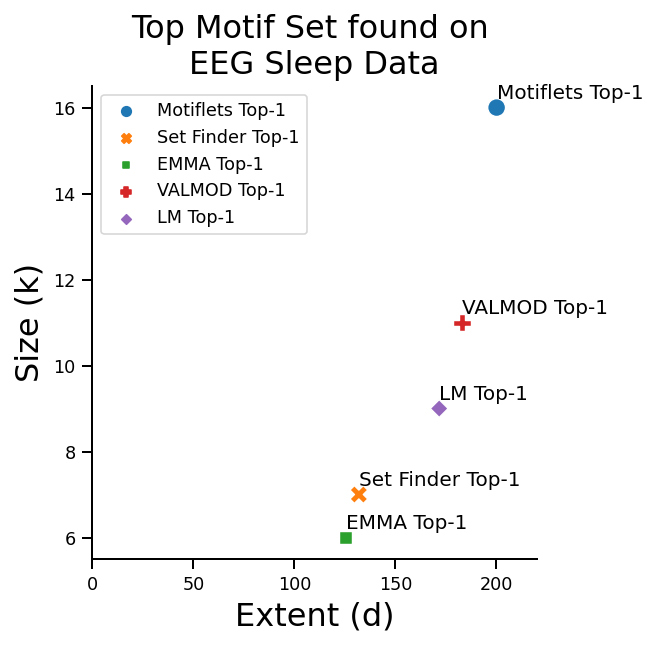

In [16]:
def annotate(ax, df):
    for ix, method, extent, cardinality, _ in df.itertuples():
        ax.annotate(
            method,
            (extent, cardinality+0.2),
            size = 10
        )

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_statistics, 
                x="Extent (d)", y="Size (k)", hue="Method", 
                style="Method", s=80, ax=ax)
annotate(ax, df_statistics)
ax.set_xlim([0, 220])
ax.set_title("Top Motif Set found on \n"+ ds_name)
ax.legend(loc="upper left")
sns.despine()
plt.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(5)
#plt.savefig("../images/" + ds_name.replace(" ", "-") + "_compare.pdf", bbox_inches='tight')

# Compare Relationship between size and extent

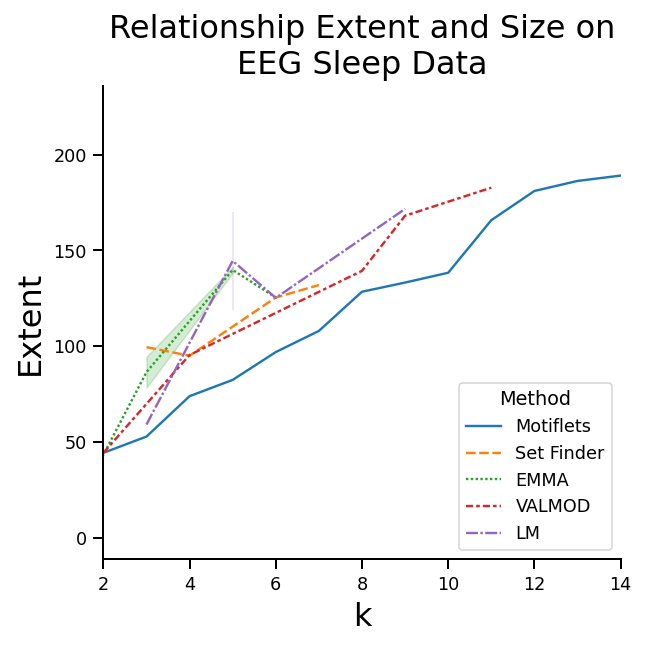

In [17]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("Relationship Extent and Size on\n" + ds_name)
sns.lineplot(x="k", y="Extent", data=df_comp, hue="Method", style="Method")
sns.despine()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([2,14])
plt.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(5)
#plt.savefig("../images/" + ds_name.replace(" ", "-")  + "_compare2.pdf", bbox_inches='tight')